In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from util import *
pd.set_option('display.max_rows', 250)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import



import time
import progressbar
bar = progressbar.ProgressBar(maxval=20, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])


## Load the COMPAS dataset

In [2]:
# Load COMPAS data
X,y,sensitive_features = load_compas_X_y_s(datasets)
P0 = np.sum(sensitive_features=='African-American')/len(sensitive_features)

# Split dataset into 4 sub-groups and retrieve the indices
subgroups_indices = get_lable_group_index(X, y, sensitive_features)

In [3]:
X.shape

(5278, 10)

In [4]:
P0

0.6015536187949981

In [5]:
y_aa = y[sensitive_features == 'African-American']
y_c = y[sensitive_features != 'African-American']

## Define a model for the study of long-term impact of fairness contraints in COMPAS

### Initial qualification rates
We randomly sample beginning points from 0 to 1. As shown in the following figure. 

In [6]:
alpha0_ini,alpha1_ini = np.sum(y_aa)/len(y_aa),np.sum(y_c)/len(y_c)
print(np.sum(y_aa)/len(y_aa),np.sum(y_c)/len(y_c))

0.5231496062992126 0.3908701854493581


### Transition probability 
-  $P(Y_{t+1} = 1 \mid Y_t = y, A_t = a, S=s)$, represented by an array T[ y, a, s]: the probability to be qualified given the current qualification state $Y_t=y$, decision $A_t = a$, and the group $S=s$, i.e.,
- The following defined transition is under Condition 1(ii) in the paper.


### Dynamics
$\alpha^s_{t+1} = g^{0s}_t + (g^{1s}_t-g^{0s}_t) \alpha^s_t$.  
- $g^{0s}_t = T[0,0,s]\mathbb{E}_{X\mid 0,s}(\hat{Y} = 0) + T[0,1,s] \mathbb{E}_{X\mid 0,s}(\hat{Y} = 1)$  
- $g^{1s}_t = T[1,0,s] \mathbb{E}_{X\mid 1,s}(\hat{Y} = 0) + T[1,1,s] \mathbb{E}_{X\mid 1,s}(\hat{Y} = 1)$
- T[ y, a, s] represents $P(Y_{t+1} = 1 \mid Y_t = y, A_t = a, S=s)$.  
- E[ y, a, s] represents $\mathbb{E}_{X\mid y,s}(\hat{Y} = a)$.

In [7]:
def update(alpha,tpr,fpr,T, group):
    if group == 0:
        gp = "African-American"
    else:
        gp = "Caucasian"
    g0 = T[0,0,group]*(1-fpr[gp]) + T[0,1,group]*fpr[gp]
    g1 = T[1,0,group]*(1-tpr[gp]) + T[1,1,group]*tpr[gp]
    return alpha*g1 + (1-alpha)*g0

### Balanced equation

In [8]:
def balance_diff(alpha,tpr,fpr,T, group):
    if group == 0:
        gp = "African-American"
    else:
        gp = "Caucasian"
    g0 = T[0,0,group]*(1-fpr[gp]) + T[0,1,group]*fpr[gp]
    g1 = T[1,0,group]*(1-tpr[gp]) + T[1,1,group]*tpr[gp]
    return g0 + (g1-g0-1)*alpha 

## The evolution trajectory of qualification states   

In this study, we consider the demographic invariant generation case. The generation distribution is not changed over time, but the ratio of different subgroups is changed, i.e., the qualification rate. Therefore, we can use resampling to get the dataset at each time step.

*The algorithm:*
1. Compute the ratio for each subgroup;  
2. Sample from the original dataset according to the subgroup-wised ratio;  
3. Apply a classifier to estimating the decision boundary;
4. Apply the dynamics to compute the ratio in next time step.
 

In [9]:
def update_qualification_rates(alpha0, alpha1, ps, T, eva_classifier_fn,
                               X, y, sensitive_features, subgroups_indices):
    # Step 1: Compute ratios
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    #  Step 2: sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = data_resampling(X,y,sensitive_features,subgroups_indices,ratio)

    #  Step 3: train (fair) classifiers, and estimate the quantity for dynamics
    pr,acc,tpr,fpr = eva_classifier_fn(X_train,y_train,sensitive_features_train)

    # Step 4: Update qualification rates
    alpha0_next = update(alpha0,tpr,fpr,T,group=0)
    alpha1_next = update(alpha1,tpr,fpr,T,group=1)
    return alpha0_next,alpha1_next

In [10]:
def compute_balance_diff(alpha0,alpha1,ps,T,eva_classifier_fn,
                         X,y,sensitive_features,subgroups_indices):
    # Step 1: Compute ratios
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    # Step 2: sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = data_resampling(X,y,sensitive_features,subgroups_indices,ratio)

    # Step 3: train (fair) classifiers, and estimate the quantity for dynamics
    pr,acc,tpr,fpr = eva_classifier_fn(X_train,y_train,sensitive_features_train)
    
    # Step 4: Compute the balanced difference for balanced functiona/curves
    group0_UN = balance_diff(alpha0,tpr,fpr,T,group=0)
    group1_UN = balance_diff(alpha1,tpr,fpr,T,group=1)
    return group0_UN, group1_UN

In [11]:
def get_val_equilibrium(eq):
    eq = np.array(eq)
    return np.unique(np.around(eq, decimals=2))


### Optimal policy

0.9;0.9;0.900000000001;0.990000000001;0.9990000000000001114

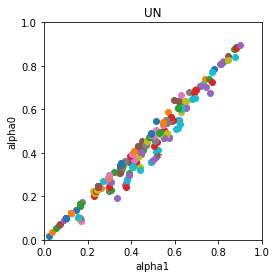

In [12]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50
plt.figure()

eq0_all=[]
eq1_all=[]

T = np.zeros((2, 2, 2))

T00 = np.linspace(0.1,0.9,5)
T10 = np.linspace(0.1,0.9,5)
T_r = np.linspace(0.1,0.9,5)
for tr in T_r:
    for t00 in T00:
        for t10 in T10:
            sys.stdout.write("\r{0}".format(str(t00) + ';' +str(t10)+ ';' +str(tr)))
            T[0,0,0] = t00
            T[0,1,0] = T[0,0,0]*tr
            T[1,0,0] = t10
            T[1,1,0] = T[1,0,0]*tr
            T[:,:,1]=T[:,:,0]

            alpha0, alpha1 =  alpha0_ini,alpha1_ini
            alpha0_un_evolution=[alpha0]
            alpha1_un_evolution=[alpha1]
            for _ in range(MAX_ITERATION_EQUILIBRIUM):
                alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier,
                                                            X, y, sensitive_features, subgroups_indices)
                alpha0_un_evolution.append(alpha0)
                alpha1_un_evolution.append(alpha1)

            plt.axis('square')
            plt.xlabel('alpha1')
            plt.ylabel('alpha0')
            plt.plot(alpha1_un_evolution[-2:],alpha0_un_evolution[-2:],'o')
            plt.ylim(0, 1)
            plt.xlim(0, 1)
            eq0_all.append(alpha0_un_evolution[-2:])
            eq1_all.append(alpha1_un_evolution[-2:])
            
plt.plot(alpha0_ini,alpha1_ini,'*')
plt.title("UN")
plt.show()


In [13]:
df_un_0 = pd.DataFrame(np.array(eq0_all))
df_un_1 = pd.DataFrame(np.array(eq1_all))

df_un_0_reshape = pd.DataFrame(np.zeros((25,5)))
for i in range(5):
    df_un_0_reshape.iloc[:,i] = np.abs(np.array(eq0_all)[i*25:i*25+25,-2]-np.array(eq0_all)[i*25:i*25+25,-1])

df_un_1_reshape = pd.DataFrame(np.zeros((25,5)))
for i in range(5):
    df_un_1_reshape.iloc[:,i] = np.abs(np.array(eq1_all)[i*25:i*25+25,-2]-np.array(eq1_all)[i*25:i*25+25,-1])

df_un_0_cube = pd.DataFrame(np.zeros((25,5)))
for i in range(25):
    for j in range(5):        
        df_un_0_cube.iloc[i,j] = np.around(df_un_0_reshape.iloc[i,j], decimals=2)
df_un_1_cube = pd.DataFrame(np.zeros((25,5)))
for i in range(25):
    for j in range(5):        
        df_un_1_cube.iloc[i,j] = np.around(df_un_1_reshape.iloc[i,j], decimals=2)
df_un_cube = np.sqrt(df_un_1_cube*df_un_1_cube+df_un_0_cube*df_un_0_cube)

In [14]:
df_un_cube.to_csv('df_un_eq_cube.csv', index=False)
df_un_0_cube.to_csv('df_un_0_eq_cube.csv', index=False)
df_un_1_cube.to_csv('df_un_1_eq_cube.csv', index=False)

<IPython.core.display.Javascript object>


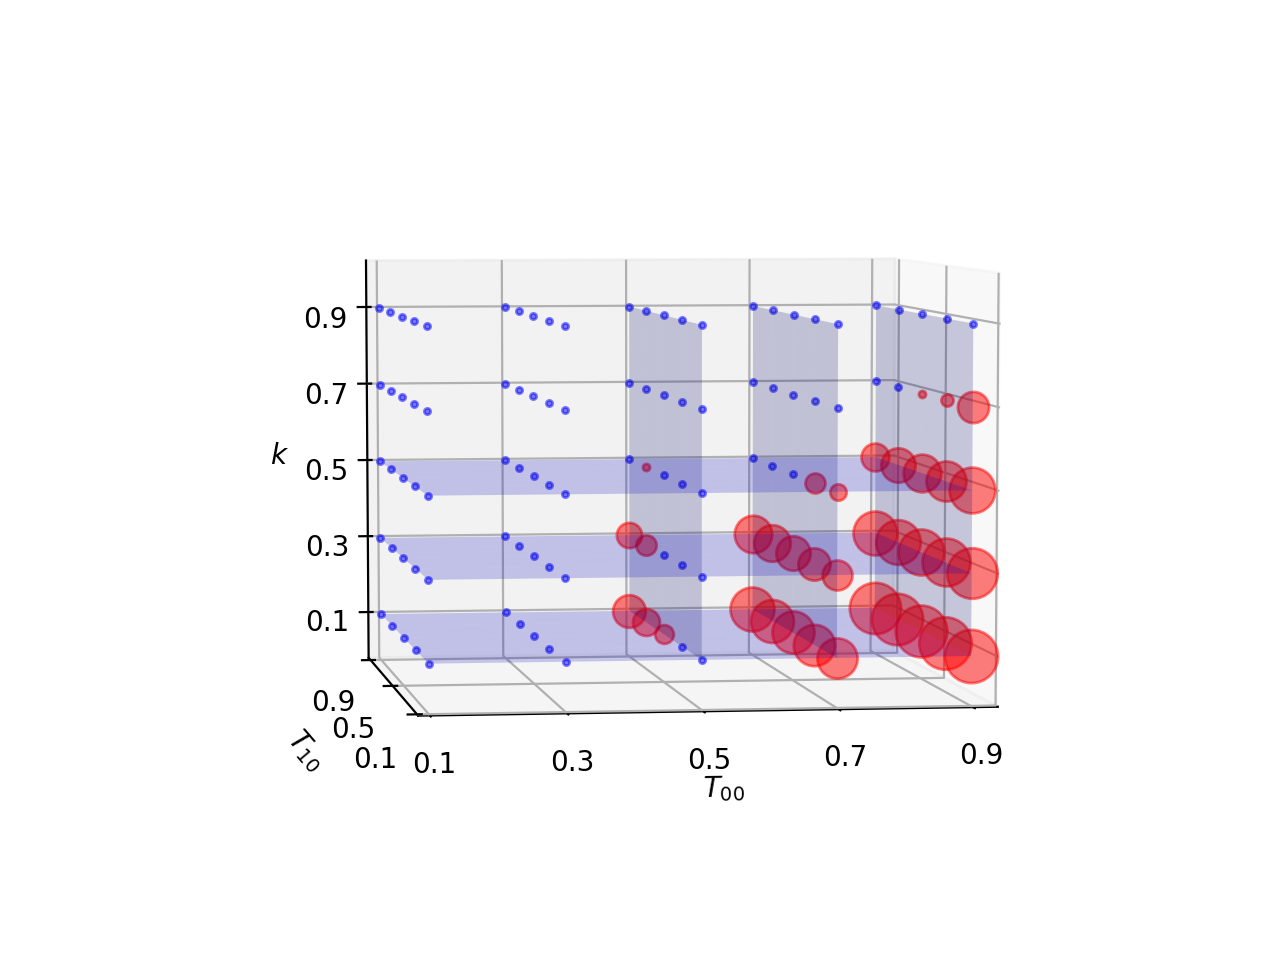

In [15]:
%matplotlib notebook

plt3d = plt.figure().gca(projection='3d')

Y_d = np.arange(0, 5, 1)
l = len(Y_d)
Z_d = np.arange(0.1,1.1, 0.2)
Y_d, Z_d = np.meshgrid(Y_d, Z_d)


X_d = np.ones((l,l))*4
plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)

X_d = np.ones((l,l))*3
plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)

X_d = np.ones((l,l))*2
plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)


X_d = np.arange(0, 5, 1)
Y_d = np.arange(0, 5, 1)
X_d, Y_d = np.meshgrid(X_d, Y_d)

Z_d = np.ones((l,l))*0.1
plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)

Z_d = np.ones((l,l))*0.3
plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)

Z_d = np.ones((l,l))*0.5
plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)



# Ensure that the next plot doesn't overwrite the first plot
ax = plt.gca()
# plt.hold(True)


equil_index = []
osci_index = []
for i in range(5):
    for j in range(5):
        for k in range(5):
            if df_un_cube.iloc[i*5+j,k] < 0.02:
                ax.scatter(i, j, T_r[k], 
                       marker='.',c='b',
                       alpha = 0.5)
                equil_index.append((i,j,k))
            else:
                ax.scatter(i, j, T_r[k], 
                           s=20*15*df_un_cube.iloc[i*5+j,k], 
                           marker='o',c='r',
                           alpha = 0.5)
                osci_index.append((i,j,k))




ax.set_xlabel('$T_{00}$')
ax.set_ylabel('$T_{10}$')
ax.set_zlabel('$k$')
plt.xticks(np.arange(0, 5, 1), [0.1,0.3,0.5,0.7,0.9])
plt.yticks([0,2,4], [0.1,0.5,0.9])

ax.set_zticks([0.1,0.3,0.5,0.7,0.9])


ax.set(xlim=(0, 4.1), ylim=(0, 4.1), zlim=(0, 1))
ax.view_init(5, -98)

plt.show()
plt.savefig('unique_eq.pdf', format='pdf')


## Oscillation States

In [16]:
osci_index_=osci_index
np.random.seed(777)
np.random.shuffle(osci_index)
rd_osci_indx = osci_index[7]
rd_osci_indx
T00_osci,T10_osci,k_osci = T00[rd_osci_indx[0]],T10[rd_osci_indx[1]],T_r[rd_osci_indx[2]]
MAX_ITERATION_EQUILIBRIUM = 50

T = np.zeros((2, 2, 2))
T[0,0,0] = T00_osci
T[0,1,0] = T[0,0,0]*k_osci
T[1,0,0] = T10_osci
T[1,1,0] = T[1,0,0]*k_osci
T[:,:,1]=T[:,:,0]

alpha0, alpha1 =  alpha0_ini,alpha1_ini
alpha0_un_evolution=[alpha0]
alpha1_un_evolution=[alpha1]

for _ in range(MAX_ITERATION_EQUILIBRIUM):
    alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, 
                                                eva_classifier,
                                                X, y, sensitive_features, subgroups_indices)
    alpha0_un_evolution.append(alpha0)
    alpha1_un_evolution.append(alpha1)
        
alpha0_un_evolution   

[0.5231496062992126,
 0.37807874015748044,
 0.48422330671577435,
 0.3856108341353218,
 0.4885305269446264,
 0.3856207451514852,
 0.48414358990557477,
 0.3806493344586021,
 0.49430112941289234,
 0.3765454424216097,
 0.49443739891247984,
 0.37406328021056723,
 0.4962759304809768,
 0.37032376214590884,
 0.4993518316915382,
 0.37297437100432357,
 0.4960230732120732,
 0.37213269863356097,
 0.5026599010114852,
 0.36641344332643977,
 0.5047294966166791,
 0.3650078489026546,
 0.5019610357707095,
 0.37085351654326953,
 0.499973063578492,
 0.3730853008735163,
 0.5003103873885814,
 0.36912495693367947,
 0.5014706217407217,
 0.3665922627194432,
 0.5036969267580884,
 0.36590144141279,
 0.5035314863745483,
 0.3648069918609788,
 0.5039489200116343,
 0.367153204984972,
 0.5038060734908464,
 0.3665675105040053,
 0.5046065948355772,
 0.3699605830765513,
 0.49922747268843587,
 0.3693765720932856,
 0.5016208235618684,
 0.3626015806772481,
 0.5063897903300398,
 0.36327399074323297,
 0.504434301114151,
 0.3671220200045413,
 0.5043417963071612,
 0.36402675934897377,
 0.5076219999981526]

## Equilibrium states

In [17]:
equil_index_=equil_index
np.random.seed(7)
np.random.shuffle(equil_index)
rd_eq_indx = equil_index[:5]
rd_eq_indx

[(0, 2, 3), (2, 0, 1), (0, 3, 2), (0, 4, 0), (0, 2, 2)]

In [18]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50
T = np.zeros((2, 2, 2))

eq0_h_all=[]
eq1_h_all=[]

eq0_l_all=[]
eq1_l_all=[]

eq0_all=[]
eq1_all=[]

for i in range(5):
    sys.stdout.write("\r{0}".format(str(i)))


    T00_eq,T10_eq,k_eq = T00[rd_eq_indx[i][0]],T10[rd_eq_indx[i][1]],T_r[rd_eq_indx[i][2]]
    
    
    T[0,0,0] = T00_eq
    T[0,1,0] = T[0,0,0]*k_eq
    T[1,0,0] = T10_eq
    T[1,1,0] = T[1,0,0]*k_eq
    T[:,:,1]=T[:,:,0]

    alpha0, alpha1 =  alpha0_ini,alpha1_ini
    alpha0_h, alpha1_h =  alpha0_ini,alpha1_ini
    alpha0_l, alpha1_l =  alpha0_ini,alpha1_ini


    alpha0_un_evolution=[alpha0]
    alpha1_un_evolution=[alpha1]
    
    alpha0_un_h_evolution=[alpha0]
    alpha1_un_h_evolution=[alpha1]
    
    alpha0_un_l_evolution=[alpha0]
    alpha1_un_l_evolution=[alpha1]
    
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, 
                                                    eva_classifier,
                                                    X, y, sensitive_features, subgroups_indices)
        
        alpha0_h, alpha1_h = update_qualification_rates(alpha0_h, alpha1_h, P0, T, 
                                                        eva_classifier_high_th,
                                                        X, y, sensitive_features, subgroups_indices)
        
        alpha0_l, alpha1_l = update_qualification_rates(alpha0_l, alpha1_l, P0, T, 
                                                        eva_classifier_low_th,
                                                        X, y, sensitive_features, subgroups_indices)
        alpha0_un_evolution.append(alpha0)
        alpha1_un_evolution.append(alpha1)
        
        alpha0_un_h_evolution.append(alpha0_h)
        alpha1_un_h_evolution.append(alpha1_h)
        
        alpha0_un_l_evolution.append(alpha0_l)
        alpha1_un_l_evolution.append(alpha1_l)
    eq0_h_all.append(np.mean(alpha0_un_h_evolution[-5:]))
    eq1_h_all.append(np.mean(alpha1_un_h_evolution[-5:]))

    eq0_l_all.append(np.mean(alpha0_un_l_evolution[-5:]))
    eq1_l_all.append(np.mean(alpha1_un_l_evolution[-5:]))

    eq0_all.append(np.mean(alpha0_un_evolution[-5:]))
    eq1_all.append(np.mean(alpha1_un_evolution[-5:]))

4

In [19]:
Table = pd.DataFrame(np.zeros((5,6)),columns=["UN0","UN0_h","UN0_l","UN1","UN1_h","UN1_l"])
Table["UN0"] = eq0_all
Table["UN1"] = eq1_all
Table["UN0_h"] = eq0_h_all
Table["UN1_h"] = eq1_h_all
Table["UN0_l"] = eq0_l_all
Table["UN1_l"] = eq1_l_all
Table

,UN0,UN0_h,UN0_l,UN1,UN1_h,UN1_l
0,0.163034,0.166275,0.141799,0.165152,0.166374,0.153728
1,0.338697,0.354762,0.302830,0.350111,0.356268,0.313865
2,0.221851,0.245594,0.148569,0.239398,0.247148,0.181728
3,0.261802,0.390440,0.124790,0.372916,0.452789,0.203509
4,0.160275,0.166049,0.132721,0.164616,0.166127,0.149836


In [20]:
Table_overall = pd.DataFrame(np.zeros((5,3)),columns=["UN","UN_h","UN_l"])
Table_overall["UN"] = np.array(eq0_all) * P0+ np.array(eq1_all)*(1-P0)
Table_overall["UN_h"] = np.array(eq0_h_all) * P0+ np.array(eq1_h_all)*(1-P0)
Table_overall["UN_l"] = np.array(eq0_l_all) * P0+ np.array(eq1_l_all)*(1-P0)
Table_overall


,UN,UN_h,UN_l
0,0.163878,0.166314,0.146552
1,0.343245,0.355362,0.307227
2,0.228843,0.246213,0.161781
3,0.306075,0.415282,0.156155
4,0.162005,0.166080,0.139540


##  Experiments for all combinations of transitions

In [21]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

eq0_all=[]
eq1_all=[]
T = np.zeros((2, 2, 2))
T00 = np.linspace(0.1,0.9,5)
T10 = np.linspace(0.1,0.9,5)
T_r = np.linspace(0.1,0.9,5)
for tr1 in T_r:
    for tr in T_r:
        for t00 in T00:
            for t10 in T10:
                sys.stdout.write("\r{0}".format(str(t00) + ';' +str(t10)+ ';' +str(tr)))
                T[0,0,0] = t00
                T[0,1,0] = T[0,0,0]*tr1
                T[1,0,0] = t10
                T[1,1,0] = T[1,0,0]*tr
                T[:,:,1]=T[:,:,0]

                alpha0, alpha1 =  alpha0_ini,alpha1_ini
                alpha0_un_evolution=[alpha0]
                alpha1_un_evolution=[alpha1]
                for _ in range(MAX_ITERATION_EQUILIBRIUM):
                    alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, P0, T, eva_classifier,
                                                                X, y, sensitive_features, subgroups_indices)
                    alpha0_un_evolution.append(alpha0)
                    alpha1_un_evolution.append(alpha1)

                eq0_all.append(alpha0_un_evolution[-2:])
                eq1_all.append(alpha1_un_evolution[-2:])
    
    
    

0.9;0.9;0.900000000001;0.990000000001;0.9990000000000001114

In [22]:
eq0_all_ = eq0_all
eq1_all_ = eq1_all

<IPython.core.display.Javascript object>


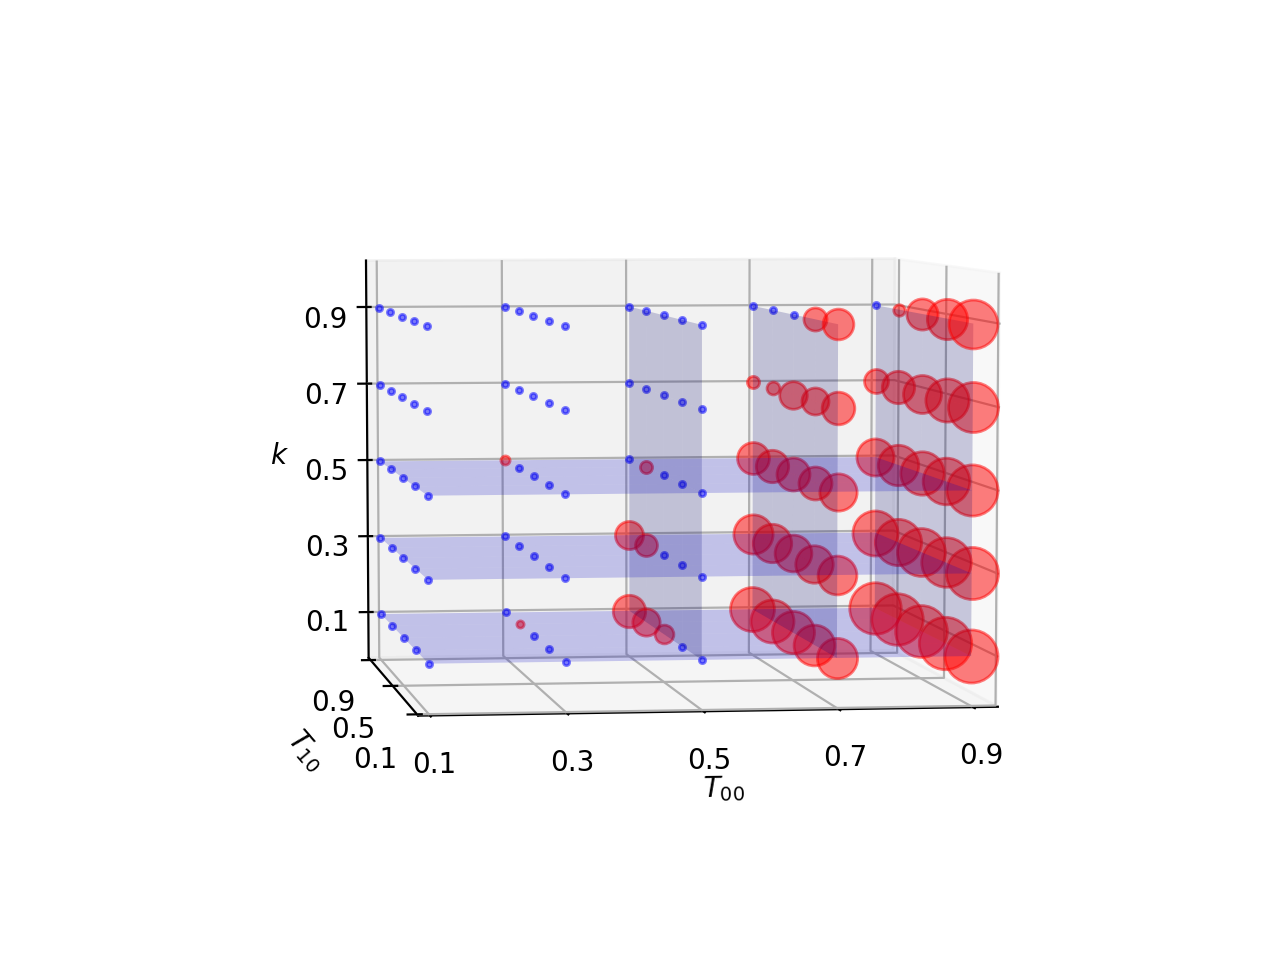

<IPython.core.display.Javascript object>


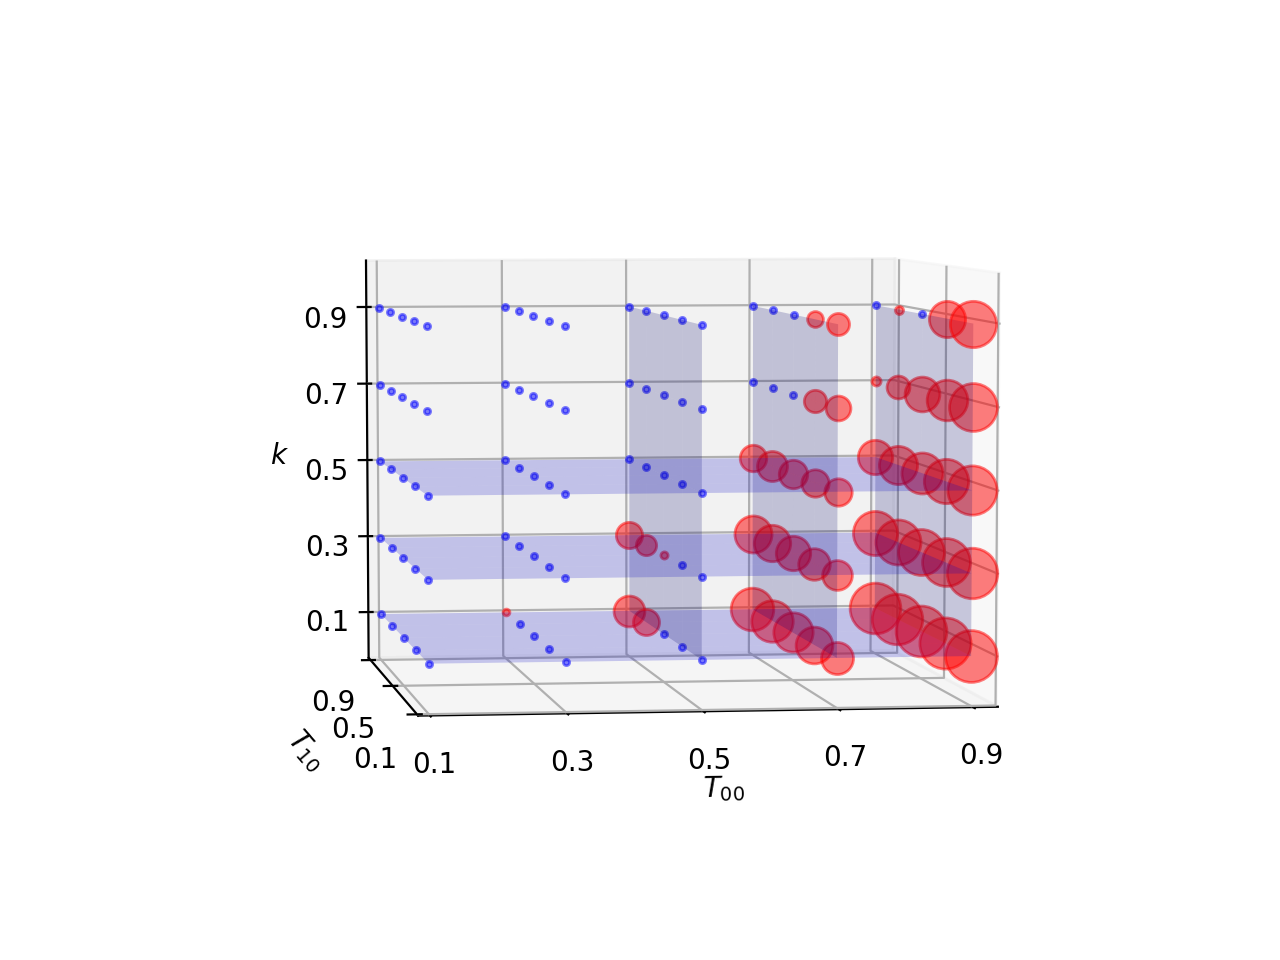

<IPython.core.display.Javascript object>


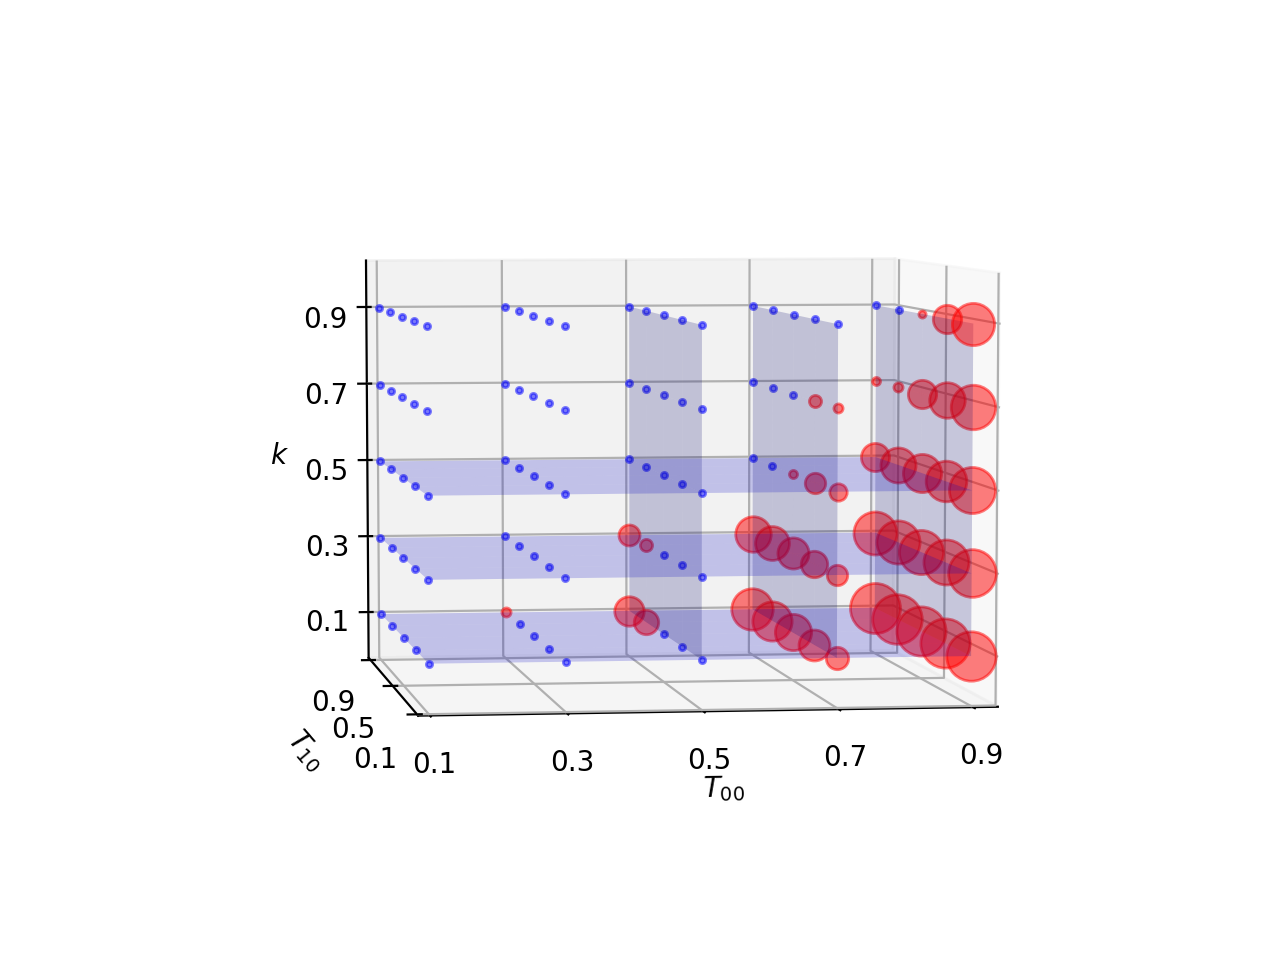

<IPython.core.display.Javascript object>


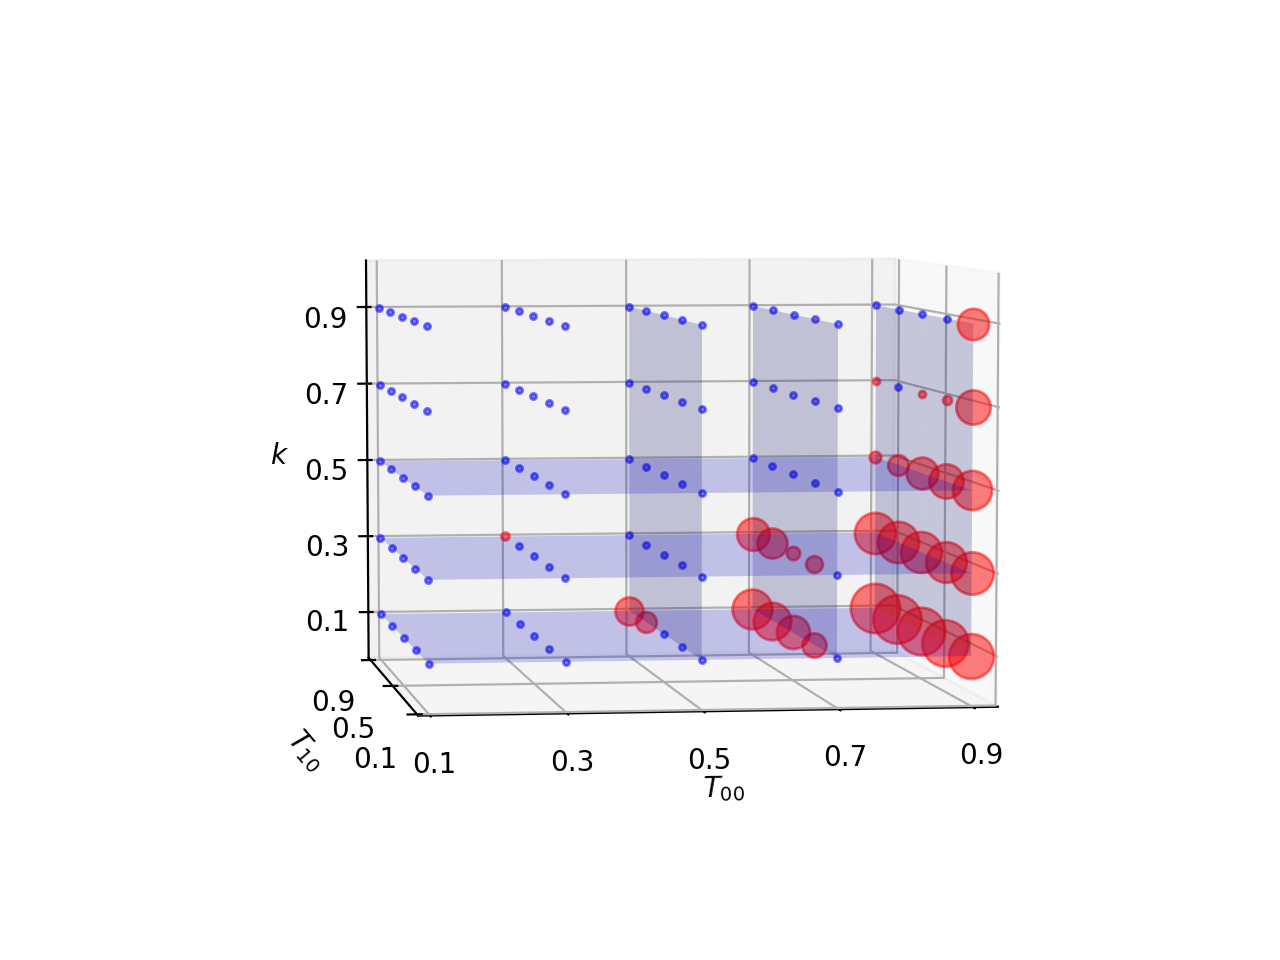

<IPython.core.display.Javascript object>


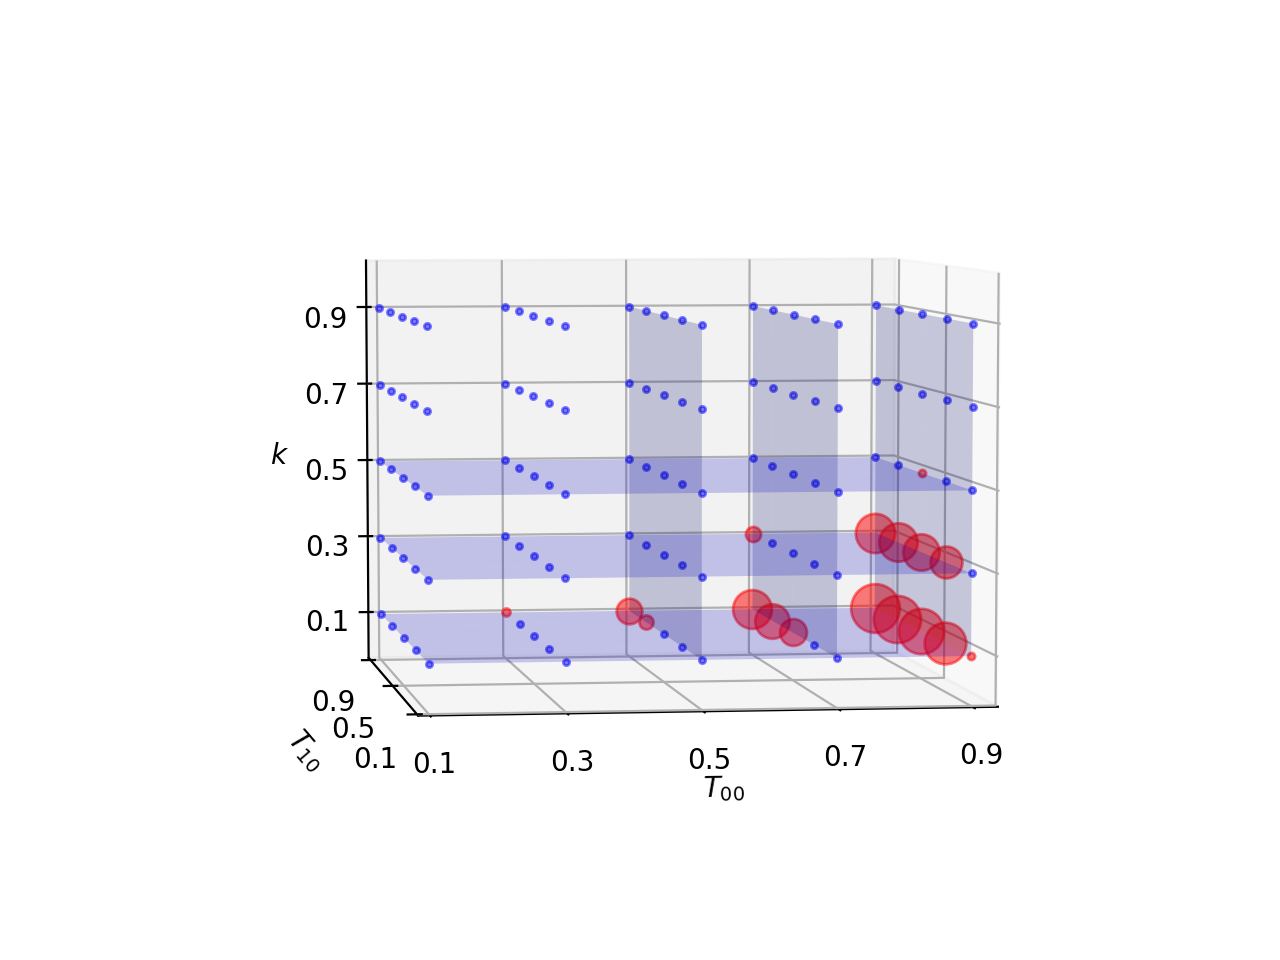

In [23]:
for index in range(5):
    df_un_0 = pd.DataFrame(np.array(eq0_all_)[125*index:125*i+125,:])
    df_un_1 = pd.DataFrame(np.array(eq1_all_)[125*index:125*i+125,:])
    eq0_all = np.array(eq0_all_)[125*index:125*index+125,:]
    eq1_all = np.array(eq1_all_)[125*index:125*index+125,:]
    df_un_0_reshape = pd.DataFrame(np.zeros((25,5)))
    for i in range(5):
        df_un_0_reshape.iloc[:,i] = np.abs(eq0_all[i*25:i*25+25,-2]-eq0_all[i*25:i*25+25,-1])

    df_un_1_reshape = pd.DataFrame(np.zeros((25,5)))
    for i in range(5):
        df_un_1_reshape.iloc[:,i] = np.abs(eq1_all[i*25:i*25+25,-2]-eq1_all[i*25:i*25+25,-1])

    df_un_0_cube = pd.DataFrame(np.zeros((25,5)))
    for i in range(25):
        for j in range(5):        
            df_un_0_cube.iloc[i,j] = np.around(df_un_0_reshape.iloc[i,j], decimals=2)
    df_un_1_cube = pd.DataFrame(np.zeros((25,5)))
    for i in range(25):
        for j in range(5):        
            df_un_1_cube.iloc[i,j] = np.around(df_un_1_reshape.iloc[i,j], decimals=2)
    df_un_cube = np.sqrt(df_un_1_cube*df_un_1_cube+df_un_0_cube*df_un_0_cube)
    plt3d = plt.figure().gca(projection='3d')

    Y_d = np.arange(0, 5, 1)
    l = len(Y_d)
    Z_d = np.arange(0.1,1.1, 0.2)
    Y_d, Z_d = np.meshgrid(Y_d, Z_d)


    X_d = np.ones((l,l))*4
    plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)

    X_d = np.ones((l,l))*3
    plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)

    X_d = np.ones((l,l))*2
    plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)


    X_d = np.arange(0, 5, 1)
    Y_d = np.arange(0, 5, 1)
    X_d, Y_d = np.meshgrid(X_d, Y_d)

    Z_d = np.ones((l,l))*0.1
    plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)

    Z_d = np.ones((l,l))*0.3
    plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)

    Z_d = np.ones((l,l))*0.5
    plt3d.plot_surface(X_d,Y_d,Z_d,color='b', alpha=0.2)

    # Ensure that the next plot doesn't overwrite the first plot
    ax = plt.gca()
    # plt.hold(True)
    # ax = fig.add_subplot(111, projection='3d')
    for i in range(5):
        for j in range(5):
            for k in range(5):
                if df_un_cube.iloc[i*5+j,k] < 0.02:
                    ax.scatter(i, j, T_r[k], 
                           marker='.',c='b',
                           alpha = 0.5)
                else:
                    ax.scatter(i, j, T_r[k], 
                               s=20*15*df_un_cube.iloc[i*5+j,k], 
                               marker='o',c='r',
                               alpha = 0.5)


    ax.set_xlabel('$T_{00}$')
    ax.set_ylabel('$T_{10}$')
    ax.set_zlabel('$k$')
    plt.xticks(np.arange(0, 5, 1), [0.1,0.3,0.5,0.7,0.9])
    plt.yticks([0,2,4], [0.1,0.5,0.9])

    ax.set_zticks([0.1,0.3,0.5,0.7,0.9])


    ax.set(xlim=(0, 4.1), ylim=(0, 4.1), zlim=(0, 1))
    ax.view_init(5, -98)
    plt.show()


    name = str(index)
    plt.savefig('unique_eq'+name+'.pdf', format='pdf')



    